## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## STEP1:Compute the camera calibration using chessboard images

### 1.0 Import dependenies

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Load images
Load the images for camera calibration.

In [39]:
pat_camera_cal = 'camera_cal/'
name_images = os.listdir(pat_camera_cal)
fullPath_images = ['{0}{1}'.format(pat_camera_cal, name_image) for name_image in name_images]

### 1.2 Compute camera calibration
Images taken by cameras all have distortions caused by the lens. Before we can use these images for self driving car, we'll need to undo the distortions.

### Q1:Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.
#### Answer:
I used 17 images taken by the same camera to computed the camera matrix and distortion coefficients. The more images we have, the more accurate camera calibration would be.

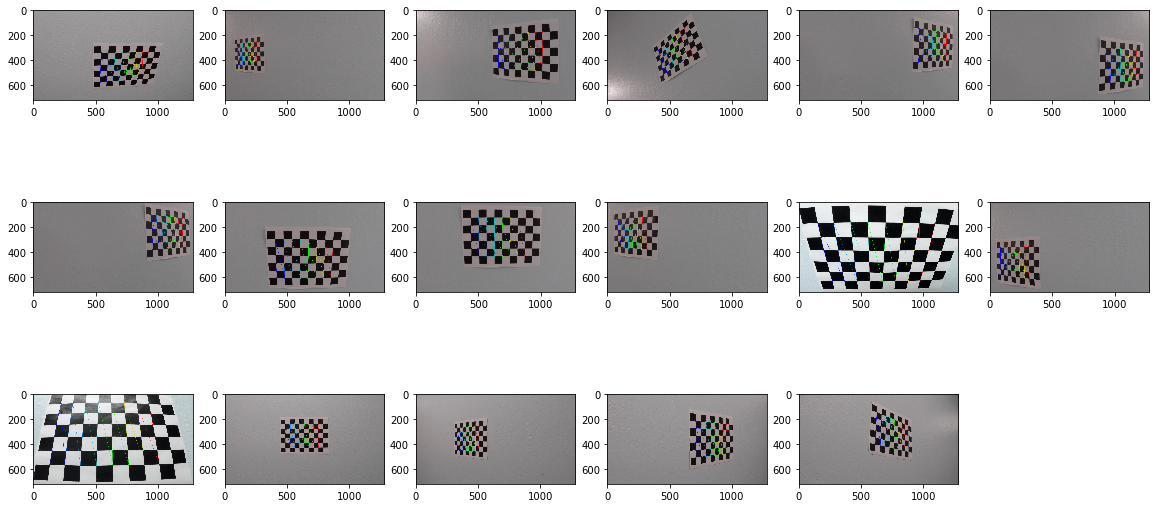

In [40]:
nx = 6
ny = 9

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
chessFound_imgs = [] # Images that are found chess boards


# Step through the list and search for chessboard corners
for index, fullpath_image in enumerate(fullPath_images):
    
    img = cv2.imread(fullpath_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        chessFound_imgs.append(img)

      
f, axs = plt.subplots(3, 6, figsize=(20, 10))
axs[-1][-1].remove() # There were 18 cells but only 17 cells are needed, remove the last one.

for index, image in enumerate(chessFound_imgs):
    idx_row = index // 6
    inx_col = index % 6
    axs[idx_row][inx_col].imshow(image)

### 1.2.5 Apply camera calibration

### Q2:Provide an example of a distortion-corrected image
#### Answer:
The distortion-corrected image is down below.

In [41]:
# Do camera calibration given object points and image points       
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)

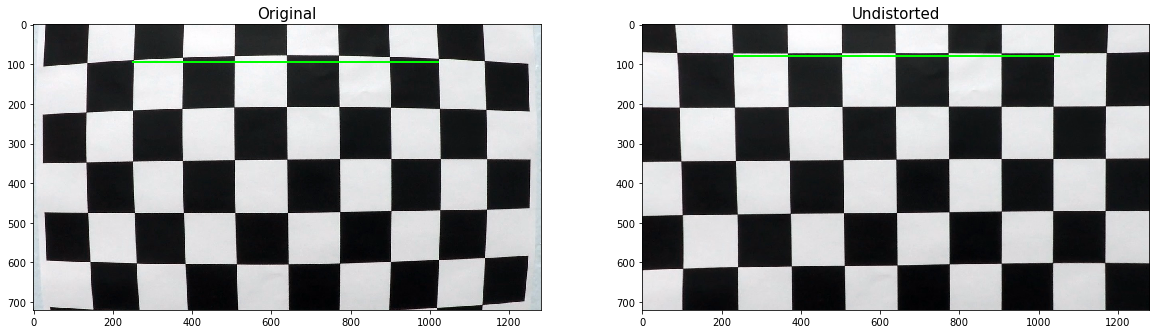

In [42]:
img = cv2.imread(fullPath_images[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Before camera calibration
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.line(img, (250, 95), (1020, 95), (0, 255, 0), 3)
ax1.imshow(img)
ax1.set_title('Original', fontsize=15)
# After camera calibration
cv2.line(dst, (230, 80), (1050, 80), (0, 255, 0), 3)
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=15)

## Step2: Laneline extraction & bird eye view

### 2.1 Helper functions
Helper functions to create thresholded binary images

In [20]:
def mask_image(image):
    imshape = image.shape
     # Masked area
    left_bottom = (150, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    mask = np.zeros_like(image)  
    
    mask = cv2.fillPoly(mask, vertices, (255, 255, 255))
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

def BGR2HLS(image, channel = None, lowbound = 90, highbound = 255):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    channels = {
                 'h' : hls[:,:,0],
                 'l' : hls[:,:,1],
                 's' : hls[:,:,2],
               }
    
    if channel != None:
        target_channel = channels.get(channel)
        assert target_channel != None, 'By selecting the target channel, please type in "h" or "l" or "s".'
        binary_output = np.zeros_like(target_channel)
        binary_output[(target_channel > lowbound) & (target_channel <= highbound)] = 1
        return binary_output
    else:
        return channels['h'], channels['l'], channels['s']
    
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.5)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,  ksize = sobel_kernel)
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    g_dir = np.arctan2(sobely_abs, sobelx_abs)
    binary_output = np.zeros_like(g_dir)
    binary_output[(g_dir >= thresh[0]) & (g_dir <= thresh[1])] = 1
    return binary_output

def magnitude_threshold(image, size_kernel = 3, threshold = (80, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = size_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = size_kernel)
    sobel_abs = np.sqrt(sobel_x**2 + sobel_y**2)
    binary_output = np.zeros_like(sobel_abs)
    binary_output[(sobel_abs <= threshold[1]) & (sobel_abs >= threshold[0])] = 1
    return binary_output

def sobel_threshold(image, direct = 'x', size_kernel = 3, threshold = (80, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if direct =='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = size_kernel)
    if direct =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = size_kernel)
    sobel = np.absolute(sobel)
    sobel_rescaled = np.uint8(sobel/np.max(sobel)*255)    
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel <= threshold[1]) & (sobel >= threshold[0])] = 1
    return binary_output

def filters_combination(image):
    hls = BGR2HLS(image,channel='s')
    direction = dir_threshold(image)
    mag = magnitude_threshold(image)
    sobel_x = sobel_threshold(image)
    sobel_y = sobel_threshold(image, direct = 'y')
    output = np.zeros_like(hls)
#     output[((hls == 1) & (direction == 1) | (mag == 1) | (sobel_x == 1) | (sobel_y == 1))] = 255
    output[((hls == 1) | (sobel_x == 1))] = 255

    return output


def perspective_transform(image, src, dst):
    image_size = image.shape[:2][::-1]
    src = np.float32(src)
    dst = np.float32(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    minV = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, image_size)
    return minV,warped

def undistortion(image):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst


def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### 2.2 Viz

S channel and sobel-X are doing great to maintain lane lines.


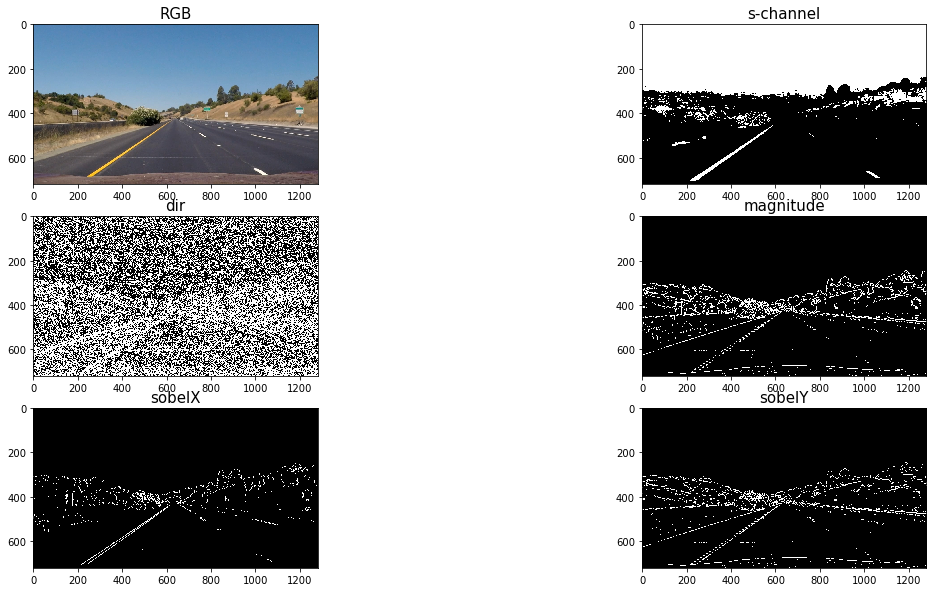

In [9]:
import os

## Load test images
path = 'test_images/'
name_testImgs = os.listdir(path)
name_testImgs = ['{0}{1}'.format(path, image) for image in name_testImgs]
num_samples = 1

## See how filters work out
for i in range(num_samples):
    name_img = name_testImgs[i]
    img = cv2.imread(name_img)
    rgb_img = BGR2RGB(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax0, ax1, ax2) = plt.subplots(3, 2, figsize=(20,10))
    
    # raw image
    ax0[0].imshow(rgb_img)
    ax0[0].set_title('RGB', fontsize=15)
    
    # s channel
    ax0[1].imshow(BGR2HLS(dst, channel='s'), cmap='gray')
    ax0[1].set_title('s-channel', fontsize=15)
    
    # direction
    ax1[0].imshow(dir_threshold(dst), cmap='gray')
    ax1[0].set_title('dir', fontsize=15)

    # magnitude
    ax1[1].imshow(magnitude_threshold(dst), cmap='gray')
    ax1[1].set_title('magnitude', fontsize=15)

    # sobelX
    ax2[0].imshow(sobel_threshold(dst), cmap='gray')
    ax2[0].set_title('sobelX', fontsize=15)

    # sobel Y
    ax2[1].imshow(sobel_threshold(dst, direct='y'), cmap='gray')
    ax2[1].set_title('sobelY', fontsize=15)
    
msg = 'S channel and sobel-X are doing great to maintain lane lines.'    
print(msg)

### Q3:Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.
#### Answer:
Sobel operations, directional gradients, color channels are common ways the create thresholded binary images. I've tried different ways to find the best solution, and found by applying  a bitwise "OR" operation on thresholded binary images generated by Sobel-x and s channel got me the best result. Also, i applied a mask to preserve only the pixels close to the lane.
Here's the example:
<img style='width:100%' src='output_images/preprocessing.png'/><br/>

### Q4:Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.
#### Answer:
To compute the perspective transform, i'm using cv2.getPerspectiveTransform() function, and cv2.warpPerspective() to generate a warped image given the perspective transform. In this case we're mapping the perspective view to a flat plane, so we need four source points and four targe points. 
Here's the example of a transformed image:<br/>
<img style='float: left;width:100%' src='output_images/perspective_transform.png'/>

In [61]:
def lane_finding(lane_warped, n_steps = 9):
    # Find the peaks
    his = np.sum(lane_warped[lane_warped.shape[0]//2:,:], axis=0) 
    mid_point = his.shape[0] // 2 
    his_left = his[:mid_point]
    his_right = his[mid_point:]
    
    height_img = lane_warped.shape[0]
    
    # The x position where the lanes are
    leftX_current = np.argmax(his_left)
    rightX_current = np.argmax(his_right) + mid_point
    
    nonzero_pixels = lane_warped.nonzero()
    nonzerox = np.array(nonzero_pixels[1])
    nonzeroy = np.array(nonzero_pixels[0])
    
    size_window = height_img // n_steps
    margin = 100
    minpix = 50
    
    # Lane points
    left_lane_inds = []
    right_lane_inds = []
    
    # Slide the searching window over the image
    for i in range(n_steps):
        # Define where the searching window is in the image
        win_y_low = height_img - ((i + 1) * size_window)
        win_y_high = height_img - (i * size_window)
        win_xleft_low = leftX_current - margin
        win_xleft_high = leftX_current + margin
        win_xright_low = rightX_current - margin
        win_xright_high = rightX_current + margin
        
        # Collect the pixels that are in the searching window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)    
    
    return nonzero_pixels, nonzerox, nonzeroy, left_lane_inds, right_lane_inds
    
    
def lane_highlighted(binary_warped, nonzerox,  nonzeroy, left_lane_inds, right_lane_inds, color_left = [255,0,0], color_right = [0,0,255]):
    output = np.dstack((binary_warped, binary_warped, binary_warped))
    output[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = color_left
    output[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = color_right
    return output

# Turn lane to polynomial
def polynomial_of_lane(binary_warped, points_x, points_y, orders = 2):
    coef = np.polyfit(points_x, points_y, orders)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    polynomial = coef[0]*ploty**2 + coef[1]*ploty + coef[2]
    return coef, polynomial


#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now the radius of curvature is in meters
    return left_curverad, right_curverad, center

# Fill poly
def drawPoly(binary_warped, left_poly, right_poly, minV):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    output = np.dstack((binary_warped, binary_warped, binary_warped)) 
    left_line_window = np.array([np.transpose(np.vstack([left_poly, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_poly, ploty])))])
    left_line_pts = np.hstack((left_line_window, right_line_window))  
    output = cv2.fillPoly(output, np.int_([left_line_pts]), (0,255, 0))
    return output


def pipeline(image):
    ### 1.Preprocess the input image    
    # Undistort
    img_shape = image.shape[:2][::-1]
    udst = undistortion(image)
    # Apply filters to get a binary image. Ep: Sobel, Hls....etc.
    fitered = filters_combination(udst)
    # Maintain the lane line by masking
    masked = mask_image(fitered)
    # Perspective transform
    src_bt_left_x = 300
    src_bt_left_y = 700
    src_bt_right_x = 1080
    src_bt_right_y = 700
    src_tp_right_x = 800
    src_tp_right_y = 500
    src_tp_left_x = 500
    src_ty_left_y = 500
    dst_bt_left_x = 300
    dst_bt_left_y = 700
    dst_bt_right_x = 900
    dst_bt_right_y = 700
    dst_tp_right_x = 1000
    dst_tp_right_y = 0
    dst_tp_left_x = 200
    dst_ty_left_y = 0
    warped_center = (dst_bt_left_x + dst_bt_right_x) // 2
    src = [[src_bt_left_x, src_bt_left_y], [src_bt_right_x, src_bt_right_y], [src_tp_right_x, src_tp_right_y], [src_tp_left_x, src_ty_left_y]] 
    dst = [[dst_bt_left_x, dst_bt_left_y], [dst_bt_right_x, dst_bt_right_y], [dst_tp_right_x, dst_tp_right_y], [dst_tp_left_x, dst_ty_left_y]]
    minV, binary_warped = perspective_transform(masked, src, dst)
    
    
    ### 2.Lane Finding
    nonzero_pixels, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = lane_finding(binary_warped)
    
    ### 3.Fit lanes to polynomials
    ceof_l, left_poly = polynomial_of_lane(binary_warped, nonzeroy[left_lane_inds], nonzerox[left_lane_inds])
    ceof_r, right_poly = polynomial_of_lane(binary_warped, nonzeroy[right_lane_inds], nonzerox[right_lane_inds])
    
    ### 4.Drawing
    draw = drawPoly(binary_warped, left_poly, right_poly, minV)
    highlight = lane_highlighted(binary_warped, nonzerox,  nonzeroy, left_lane_inds, right_lane_inds)
    draw_warped = cv2.warpPerspective(draw, minV, img_shape)
    highlight_warped = cv2.warpPerspective(highlight, minV, img_shape)
    result = cv2.addWeighted(udst, 1, draw_warped, 0.3, 0)
    result = cv2.addWeighted(result, 1, highlight_warped, 0.8, 0)
    # Show info
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature_l, curvature_r, offset_center = curvature(ceof_l, ceof_r, binary_warped)
    cv2.putText(result,'Center: ' +  str(offset_center)[:6] + 'M',(10,30), font, 1,(255,255,255),2)
    cv2.putText(result,'Curvature_L: ' +  str(curvature_l)[:6] + 'M',(10,60), font, 1,(255,255,255),2)
    cv2.putText(result,'Curvature_R: ' +  str(curvature_r)[:6] + 'M',(10,90), font, 1,(255,255,255),2)
    
    return result, fitered, draw_warped

### Q5:Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?
#### Answer:
To identify lane-line pixels , i had a function called "lane_finding()".
This function create a histogram, with this histogram I addedg up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 255, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. I can use that as a starting point for where to search for the lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.<br/>
"polynomial_of_lane()" is the function to fit the lane-line pixels positions with a polynomial given the x and y values. Lane lines weren't always straight, so in this case it fitted them to a quadratic polynomial.
### Q6:Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.?
#### Answer:
To calculate the radius of curvature and the position of the vehicle with respect to center, i defined a function "curvature()" and implemented what i learned in the "Measuring Curvature" section.

### Q7:Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.?
#### Answer:
Example images are down below.

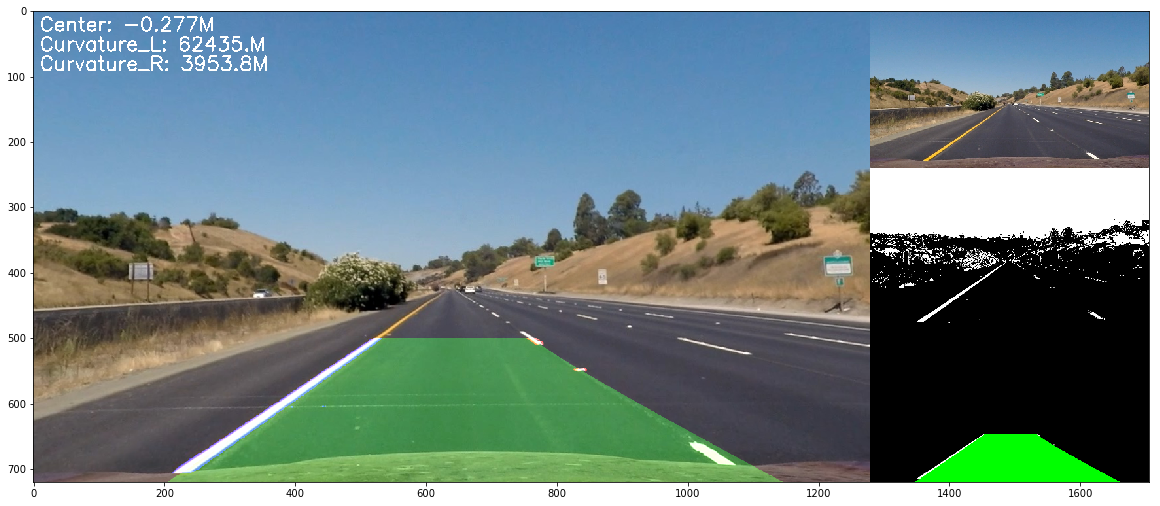

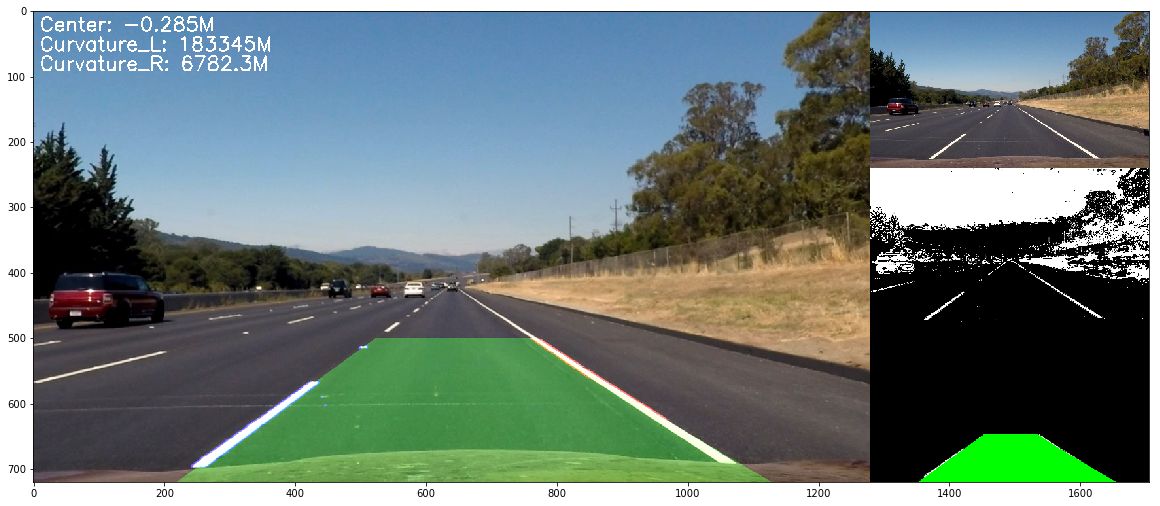

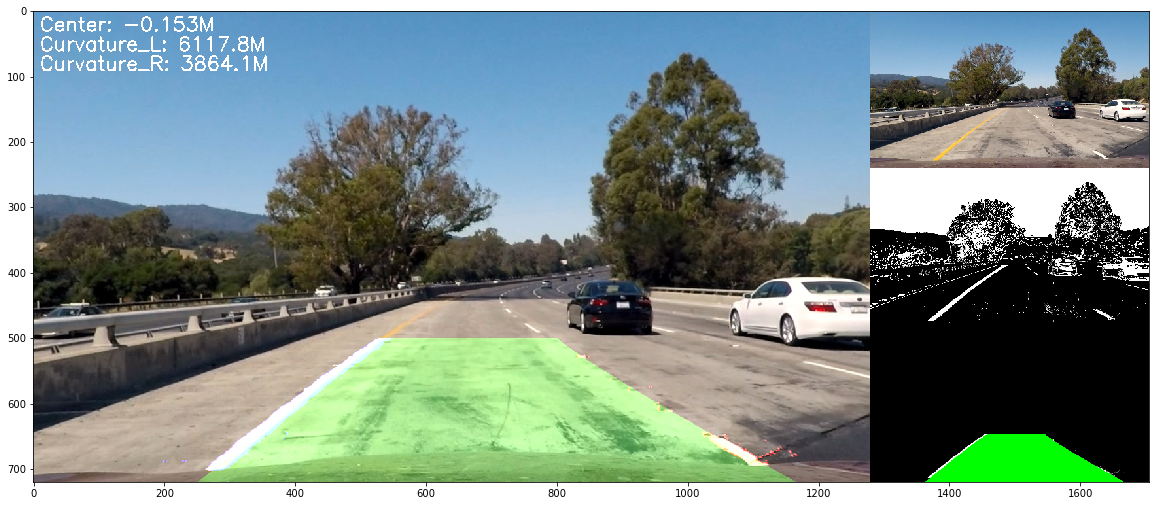

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


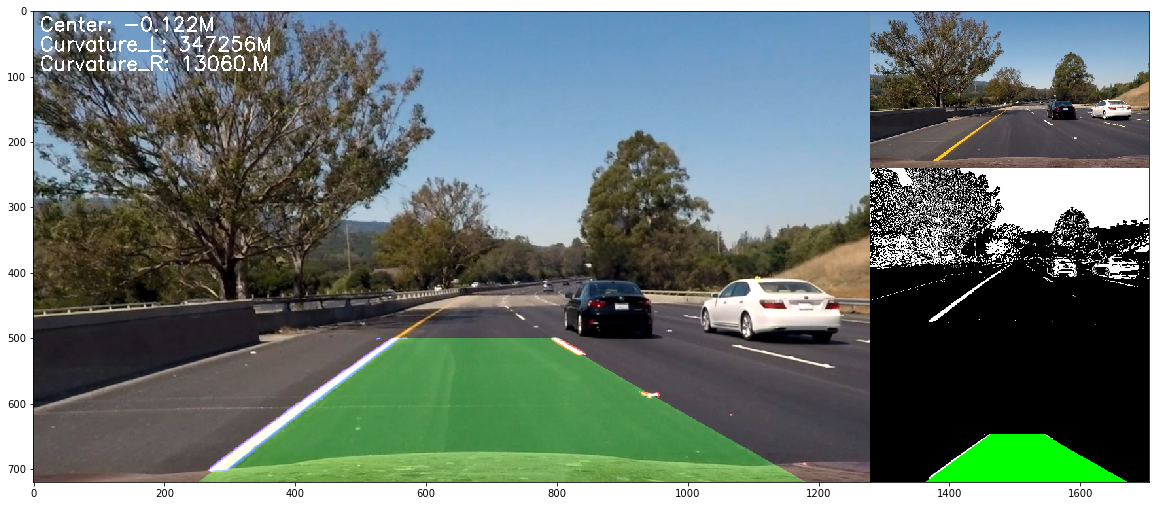

In [87]:
import os

root = 'test_images/'
imgs = os.listdir(root)
imgs = ['{0}{1}'.format(root, img_name) for img_name in imgs]
plt.figure(figsize=(10, 5))
font = cv2.FONT_HERSHEY_SIMPLEX
for img in imgs:
    f, (ax0) = plt.subplots(1, 1, figsize=(20,10))
    
    raw_img = cv2.imread(img)
    result, binary_warped, draw_warped = pipeline(raw_img)
    
    binary_warped = np.dstack((binary_warped, binary_warped, binary_warped))
    num_win_split = 3
    resize = raw_img.shape[:2][::-1]
    width = resize[0] // num_win_split
    height = resize[1] // num_win_split
    
    raw_img = cv2.resize(raw_img, (width, height))
    binary_warped = cv2.resize(binary_warped, (width, height))
    draw_warped = cv2.resize(draw_warped, (width, height))
    combined = np.vstack((raw_img, binary_warped, draw_warped))
    combined = np.hstack((result, combined))
    combined = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
    
    ax0.imshow(combined)

##  Step3 Video processing

### 3.1 Download FFMPEG for video encoding
To output videos, we need FFMPEG

In [11]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.win32.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.win32.exe (27.4 MB)
Downloading: 8192/28781056 bytes (0.016384/28781056 bytes (0.1%49152/28781056 bytes (0.2%122880/28781056 bytes (0.4253952/28781056 bytes (0.9393216/28781056 bytes (1.4516096/28781056 bytes (1.8630784/28781056 bytes (2.2761856/28781056 bytes (2.6884736/28781056 bytes (3.1999424/28781056 bytes (3.51130496/28781056 bytes (3.9%1253376/28781056 bytes (4.4%1384448/28781056 bytes (4.8%1531904/28781056 bytes (5.3%1630208/28781056 bytes (5.7%1744896/28781056 bytes (6.1%1843200/28781056 bytes (6.4%1966080/28781056 bytes (6.8%2105344/28781056 bytes (7.3%2277376/28781056 bytes (7.9%2433024/28781056 bytes (8.5%2564096/28781056 bytes (8.9%2695168/28781056 bytes (9.4%2859008/28781056 bytes (9.9%2957312/28781056 bytes (10.33088384/28781056 bytes (10.73235840/28781056 bytes (11.23366912/28781056 bytes (11.73506176/2

#### Helper function

In [25]:
def process_image(image):
    # Apply pipeline to the image to create black and white image
    img, _, _ = pipeline(image)
    return img

In [13]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Set up lines for left and right
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!?
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:21<00:00,  4.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4min 22s


###  A link to my final video output

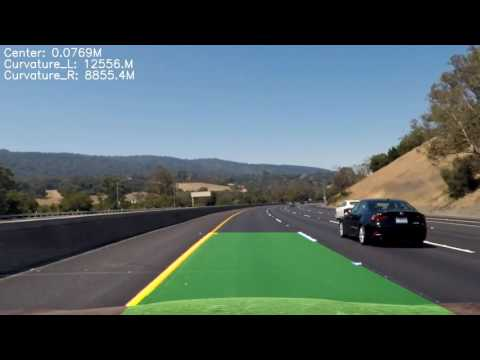

In [59]:
from IPython.display import YouTubeVideo
YouTubeVideo('1CQ9mgNllrI', width='100%')

### Q7:Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust??
#### Answer:
Even the video output showed a good accuracy on lane line finding, but there were still few frames that didn't perform well, the image down below shows one of the examples.
The line on the right was skewed because there were just a little lane-line pixels that were found, so it leaded to overfitting . This can be solved by covering a wider area when doing lane searching. Other than that i think i'm pretty satisfied with the result.
<img src='output_images/frame_the_doesnt_perform_well.png' />